Welcome to Voxelmap!

The first thing we'll do is train the neural network (Network A). We'll then test the network to see how it performs. After you've installed all the dependencies in the setup.cfg file, let's do some imports to get started.

In [1]:
# imports
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from utilities import network_a, losses
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

In [2]:
# file name and image directory
im_dir = "/srv/shared/SPARE/MC_V_P2_NS_01"
expt_description = 'Network A_SPARE_P2'
filename = 'train_a_SPARE_P2'

We recommend installing the example data at https://ses.library.usyd.edu.au/handle/2123/32282 and adding the unzipped 'data' folder to your present working directory. We'll then define our image directory as 'data/xcat/train' and define a filename to save our weights and loss plots.

Next we'll create a class called 'SupervisedDataset'. This will allow us to load the appropriate data onto the neural network for training. There are a few idiosyncrasies that we may wish to note. First, all the projection data ends in 'bin.npy' because they were originally created as binary files but were converted to .npy files for convience. The same goes for the volumes and DVFs, which end in 'mha.npy' for similar reasons. The source projection has a '06' in front because, in 4D-CTs the 6 respiratory bin corresponds with the peak-exhale phase. We name our projections 'phase_Proj_num', where phase is respiratory phase (i.e. '01', '02', ... '10') and num is the projection number (e.g. '00001'). For Networks D and E, where we train on the CoMBAT MRI data, the naming convention for slice pairs is 'phase_Slice_xc_ys' where x is the slice number along the coronal axis and y is the slice number along the sagittal axis.

An abdominal mask is used later on in the loss function to force the neural network to optimise predictions within a specific region. The data are then reshaped for the specific dimensions expected for a PyTorch neural network. Right now we are also limited to image sizes that are powers of two (e.g. projections 128x128 and volumes 128x128x128). Everything has been downsampled here to fit on the GPU.

In [3]:
# set up training dataset class
class SupervisedDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        self.im_size = im_size

    def __len__(self):
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])

    def __getitem__(self, idx):
        # Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])
        target_file = proj_list[idx]
        proj_name = os.path.join(self.im_dir, format(target_file))
        target_proj = np.load(proj_name)
        target_proj = (target_proj - np.min(target_proj)) / (np.max(target_proj) - np.min(target_proj))

        # Find target DVF
        vol_num = target_file[:2]
        dvf_name = os.path.join(self.im_dir, format('DVF_' + vol_num + '_mha.npy'))
        target_dvf = np.load(dvf_name)

        # Find source projection
        source_file = '06_' + target_file[3:]
        proj_name = os.path.join(self.im_dir, format(source_file))
        source_proj = np.load(proj_name)
        source_proj = (source_proj - np.min(source_proj)) / (np.max(source_proj) - np.min(source_proj))

        # Find source volume
        vol_name = os.path.join(self.im_dir, format('subCT_06_mha.npy'))
        source_vol = np.load(vol_name)
        source_vol = (source_vol - np.min(source_vol)) / (np.max(source_vol) - np.min(source_vol))

        # Find source abdomen
        vol_name = os.path.join(self.im_dir, format('sub_Abdomen_mha.npy'))
        source_hull = np.load(vol_name)

        # Reshape data
        source_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        source_projections[0, :, :] = np.asarray(source_proj)
        target_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        target_projections[0, :, :] = np.asarray(target_proj)

        source_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_volumes[0, :, :, :] = np.asarray(source_vol)
        source_abdomen = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_abdomen[0, :, :, :] = np.asarray(source_hull)

        target_flow = np.zeros((3, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_flow[0, :, :, :] = target_dvf[:, :, :, 0]
        target_flow[1, :, :, :] = target_dvf[:, :, :, 1]
        target_flow[2, :, :, :] = target_dvf[:, :, :, 2]

        data = {'source_projections': torch.from_numpy(source_projections),
                'target_projections': torch.from_numpy(target_projections),
                'source_volumes': torch.from_numpy(source_volumes),
                'source_abdomen': torch.from_numpy(source_abdomen),
                'target_flow': torch.from_numpy(target_flow)}

        return data

Here is a small visualization of the first 3 projection files within the source subfolder

Lookin' good! Now we will create training and validation datasets

 You can see the difference between the source projection images on both days! As the anatomy may have changed between pre-treatment and intra-treatment days.

Network time! Let's set up a cuda implementation of the network, a loss function (good ol' MSE will do! but we're computing it within a thoracoabdominal mask) and an optimizer

Are you ready? Next thing to do is to train the network :) We'll save the weights and a plot of the loss curves. We recommend training for 50 epochs. (Using a NVIDIA RTX A6000, this will take 6-8 hours, so we may need to come back tomorrow.)

Let's instantiate the validation dataset class, set up a cuda implementation, and load the pre-trained weights of our network. We'll also print the number of trainable parameters for our records.

In [7]:
# generate train/test split
im_size = 128
batch_size = 8
dataset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
split = [int(len(dataset) * 0.9), int(len(dataset) * 0.1)]
trainset, valset = torch.utils.data.dataset.random_split(dataset, split)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Training (on cuda:0)...
Starting at epoch 5 (target total: 50)
Epoch: 5 | train loss: 0.2438 | val loss: 0.2007 | total time: 0 hours 19 minutes
Epoch: 6 | train loss: 0.1940 | val loss: 0.1626 | total time: 0 hours 39 minutes
Epoch: 7 | train loss: 0.1554 | val loss: 0.1331 | total time: 0 hours 59 minutes
Epoch: 8 | train loss: 0.1284 | val loss: 0.1088 | total time: 1 hours 19 minutes
Epoch: 9 | train loss: 0.1070 | val loss: 0.0893 | total time: 1 hours 39 minutes
Epoch: 10 | train loss: 0.0931 | val loss: 0.0747 | total time: 1 hours 59 minutes
Epoch: 11 | train loss: 0.0799 | val loss: 0.0700 | total time: 2 hours 19 minutes
Epoch: 12 | train loss: 0.0702 | val loss: 0.0594 | total time: 2 hours 39 minutes
Epoch: 13 | train loss: 0.0631 | val loss: 0.0533 | total time: 2 hours 59 minutes
Epoch: 14 | train loss: 0.0600 | val loss: 0.0518 | total time: 3 hours 19 minutes
Epoch: 15 | train loss: 0.0543 | val loss: 0.0450 | total time: 3 hours 36 minutes
Epoch: 16 | train loss: 0.052

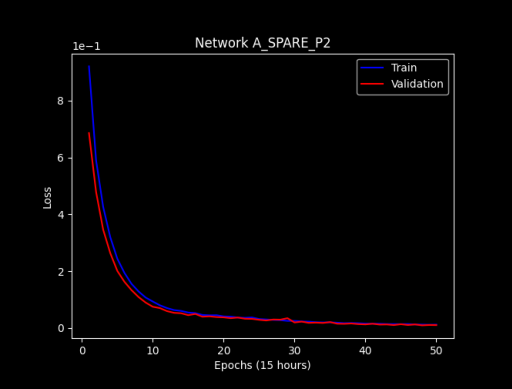

In [14]:
# =========================
# TRAIN (supports resume)
# =========================

import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

from continue_training import (
    save_checkpoint,
    load_checkpoint_if_available,
    plot_losses,
)

# ---- device (pick one and keep it consistent) ----
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---- set up network (EXACTLY as before) ----
model = network_a.model(im_size, int_steps=10).to(device)

# ---- loss + optimizer ----
flow_mask = losses.flow_mask()
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

print('Training (on ' + str(device) + ')...')
tic = time.time()

# IMPORTANT:
# epoch_num is the TOTAL epoch you want to reach.
# If you trained to 50 and want to continue to 100, set epoch_num = 100.
epoch_num = 50

save_dir = "weights"
plot_dir = "plots"
os.makedirs(save_dir, exist_ok=True)

# ---- resume (loads model+optimizer+history if checkpoint exists) ----
ckpt_path = os.path.join(save_dir, f"{filename}_ckpt.pth")
start_epoch, min_val_loss, train_losses, val_losses = load_checkpoint_if_available(
    ckpt_path=ckpt_path,
    model=model,
    optimizer=optimizer,
    device=device,
)

print(f"Starting at epoch {start_epoch} (target total: {epoch_num})")

# ---- training loop ----
for epoch in range(start_epoch, epoch_num + 1):
    model.train()
    train_loss = 0.0

    for data in trainloader:
        source_proj = data['source_projections'].to(device)
        target_proj = data['target_projections'].to(device)
        source_vol = data['source_volumes'].to(device)
        source_abdomen = data['source_abdomen'].to(device)
        target_flow = data['target_flow'].to(device)

        optimizer.zero_grad(set_to_none=True)
        _, predict_flow = model.forward(source_proj, target_proj, source_vol)
        loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for valdata in valloader:
            source_proj = valdata['source_projections'].to(device)
            target_proj = valdata['target_projections'].to(device)
            source_vol = valdata['source_volumes'].to(device)
            source_abdomen = valdata['source_abdomen'].to(device)
            target_flow = valdata['target_flow'].to(device)

            _, predict_flow = model.forward(source_proj, target_proj, source_vol)
            loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
            val_loss += loss.item()

    # ---- metrics ----
    toc = time.time()
    time_elapsed = (toc - tic) / 3600
    hours = int(np.floor(time_elapsed))
    minutes = int((time_elapsed - hours) * 60)

    train_avg = train_loss / len(trainloader)
    val_avg = val_loss / len(valloader)

    print('Epoch: %d | train loss: %.4f | val loss: %.4f | total time: %d hours %d minutes' %
          (epoch, train_avg, val_avg, hours, minutes))

    train_losses.append(train_avg)
    val_losses.append(val_avg)

    # ---- save best weights (inference) ----
    best_path = os.path.join(save_dir, f"{filename}_best.pth")
    if val_avg < min_val_loss:
        min_val_loss = val_avg
        torch.save(model.state_dict(), best_path)

    # ---- save resume checkpoint (continue training) ----
    save_checkpoint(
        ckpt_path=ckpt_path,
        model=model,
        optimizer=optimizer,
        epoch=epoch,            # last completed epoch
        best_val=min_val_loss,
        train_losses=train_losses,
        val_losses=val_losses,
    )

    # ---- plot ----
    plot_losses(
        plot_dir=plot_dir,
        filename=filename,
        expt_description=expt_description,
        train_losses=train_losses,
        val_losses=val_losses,
        hours=hours,
        minutes=minutes,
    )

print('Finished training')
torch.cuda.empty_cache()

# Show final plot
final_plot = os.path.join(plot_dir, f"{filename}.png")
if os.path.exists(final_plot):
    plt.imshow(plt.imread(final_plot))
    plt.axis("off")
    plt.show()


In [50]:
# file names
expt_file = 'train_a_SPARE_patient2'
test_file = '/srv/shared/SPARE/MC_V_P2_SC_02' # We are using the treatment day dataset with scatter
target_itv_ptv_dir = '/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetITV' # PLEASE CHANGE TO YOUR DIR


In [55]:
import os
import numpy as np
import torch
from utilities import spatialTransform


def _ensure_src_ptv_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[None, None, ...]
    elif x.ndim == 5:
        pass
    else:
        raise ValueError(f"Unsupported source PTV shape {x.shape}")
    return x.astype(np.float32)


def _ensure_dvf_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 4 and x.shape[-1] == 3:
        x = np.transpose(x, (3, 0, 1, 2))[None, ...]
    elif x.ndim == 4 and x.shape[0] == 3:
        x = x[None, ...]
    elif x.ndim == 5 and x.shape[1] == 3:
        pass
    else:
        raise ValueError(f"Unsupported DVF shape {x.shape}")
    return x.astype(np.float32)


def generate_target_itv_ptv_10bins(
    im_dir: str,
    out_dir: str,
    im_size: int = 128,
    dvf_folder: str | None = None,
    source_ptv_relpath: str = os.path.join("sub_PTV_mha.npy"),
    dvf_pattern: str = "DVF_{:02d}_mha.npy",
    out_pattern: str = "Target_PTV_{:02d}_mha.npy",
):
    """
    Saves Target ITV PTVs into out_dir.
    """
    if dvf_folder is None:
        dvf_folder = im_dir

    os.makedirs(out_dir, exist_ok=True)

    src_ptv_path = os.path.join(im_dir, source_ptv_relpath)
    if not os.path.exists(src_ptv_path):
        raise FileNotFoundError(f"Missing source ITV PTV: {src_ptv_path}")

    source_ptv_np = _ensure_src_ptv_5d(np.load(src_ptv_path))
    if source_ptv_np.shape[-3:] != (im_size, im_size, im_size):
        raise ValueError(f"Source PTV spatial shape {source_ptv_np.shape[-3:]} != {(im_size,)*3}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    transformer = spatialTransform.Network([im_size, im_size, im_size]).to(device).eval()

    source_ptv_t = torch.from_numpy(source_ptv_np).to(device)

    for b in range(1, 11):
        dvf_path = os.path.join(dvf_folder, dvf_pattern.format(b))
        if not os.path.exists(dvf_path):
            raise FileNotFoundError(f"Missing DVF file: {dvf_path}")

        dvf_np = _ensure_dvf_5d(np.load(dvf_path))
        if dvf_np.shape[-3:] != (im_size, im_size, im_size):
            raise ValueError(f"DVF spatial shape mismatch for {dvf_path}")

        dvf_t = torch.from_numpy(dvf_np).to(device)

        with torch.no_grad():
            tgt_ptv_t = transformer(source_ptv_t, dvf_t)

        tgt_ptv_np = tgt_ptv_t.detach().cpu().numpy()  # [1,1,D,H,W]

        out_path = os.path.join(out_dir, out_pattern.format(b))
        np.save(out_path, tgt_ptv_np)
        print(f"Saved {out_path}")

    print("Done. Target ITV PTVs saved.")

# Save into MC_V_P1_SC_02/Target_ITV/
generate_target_itv_ptv_10bins(
    im_dir="/srv/shared/SPARE/MC_V_P2_SC_02",
    out_dir="/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV",
    im_size=128,
)


Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_01_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_02_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_03_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_04_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_05_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_06_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_07_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_08_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_09_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_10_mha.npy
Done. Target ITV PTVs saved.


Lets visualize this created target_ITV_PTV

PTV shape: (128, 128, 128)
Unique values (approx): [0.0000000e+00 4.4581026e-05 1.0667859e-04 2.2544760e-04 3.1016947e-04]


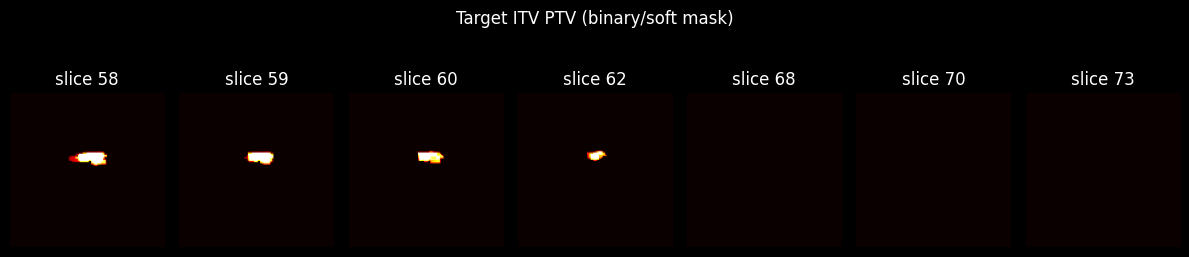

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Load PTV volume
ptv_path = "/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_01_mha.npy"
ptv = np.squeeze(np.load(ptv_path))  # shape should be (128,128,128)

print("PTV shape:", ptv.shape)
print("Unique values (approx):", np.unique(ptv)[:5])

# Choose a slice axis (change axis if needed: 0, 1, or 2)
axis = 2
ptv_slices = np.moveaxis(ptv, axis, 0)

# Show 5 evenly spaced slices
idxs = [58, 59, 60, 62, 68,70,73]

plt.figure(figsize=(12, 3))
for i, idx in enumerate(idxs):
    plt.subplot(1, 7, i+1)
    plt.imshow(ptv_slices[idx], cmap="hot")
    plt.title(f"slice {idx}")
    plt.axis("off")

plt.suptitle("Target ITV PTV (binary/soft mask)")
plt.tight_layout()
plt.show()


In [57]:
import os
import shutil
import csv

# Paths
target_itv_dir = "/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV"
respbin_csv = "/srv/shared/SPARE/MC_V_P2_SC_02/RespBin.csv"
output_dir = "/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/Target_ITV_PTVs_All"

os.makedirs(output_dir, exist_ok=True)

targets_created = 0

# Read CSV for mapping
with open(respbin_csv, newline='') as csvfile:
    reader = csv.reader(csvfile)

    for target_idx, row in enumerate(reader, start=1):

        # Skip empty rows
        if not row:
            continue

        # Single column = breathing phase
        breathing_phase = int(row[0])
        if not (1 <= breathing_phase <= 10):
            raise ValueError(
                f"Invalid breathing phase {breathing_phase} at target {target_idx}"
            )

        phase_str = f"{breathing_phase:02d}"

        src_itv = os.path.join(
            target_itv_dir,
            f"Target_PTV_{phase_str}_mha.npy"
        )

        if not os.path.exists(src_itv):
            raise FileNotFoundError(f"Missing ITV file: {src_itv}")

        dst_itv = os.path.join(
            output_dir,
            f"Target_{target_idx:05d}_ITV_PTV.npy"
        )

        shutil.copy(src_itv, dst_itv)
        targets_created += 1

        if targets_created % 50 == 0:
            print(f"Processed {targets_created} targets...")

print(f"\n Successfully created {targets_created} Target ITV PTVs")
print(f" Output directory: {output_dir}")


Processed 50 targets...
Processed 100 targets...
Processed 150 targets...
Processed 200 targets...
Processed 250 targets...
Processed 300 targets...
Processed 350 targets...
Processed 400 targets...
Processed 450 targets...
Processed 500 targets...
Processed 550 targets...
Processed 600 targets...
Processed 650 targets...

 Successfully created 680 Target ITV PTVs
 Output directory: /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/Target_ITV_PTVs_All


In [45]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class validateSPAREDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        # Source files (Phase 06) and global contours are in the 'source' subfolder Within the Treatment Day Dataset
        self.ref_dir = os.path.join(im_dir, 'source')
        self.im_size = im_size

    def __len__(self):
        # Count target projections (excluding phase 06 reference files)
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])

    def __getitem__(self, idx):
        # 1. Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])
        target_file = proj_list[idx]
        target_proj = np.load(os.path.join(self.im_dir, target_file))

        # 2. Find target volume using RespBin.csv logic
        resp_bin_path = os.path.join(self.im_dir, 'RespBin.csv')
        resp_bins = np.genfromtxt(resp_bin_path)
        bin_val = int(resp_bins[idx])

        # Format the volume number (e.g., 1 -> '01', 10 -> '10')
        if bin_val < 10:
            vol_num = '0' + str(bin_val)
        else:
            vol_num = str(bin_val) # Assuming 10 is the max, else use str(bin_val)

        # Load the volume corresponding to the bin index
        target_vol = np.load(os.path.join(self.im_dir, f'subCT_{vol_num}_mha.npy'))

        # 3. Find source data (Reference Phase 06) from the 'source' folder
        # Reconstructs source filename (e.g., 01_Proj_001.npy -> 06_Proj_001.npy)
        source_proj_name = '06_'+"Proj_" + '_'.join(target_file.split('_')[1:])
        source_proj = np.load(os.path.join(self.ref_dir, source_proj_name))

        source_vol = np.load(os.path.join(self.im_dir, 'subCT_06_mha.npy'))

        # 4. Find restricted contours (Lung and PTV only) from 'source' folder
        #source_lung = np.load(os.path.join(self.ref_dir, 'itv_Lung_mha.npy'))
        source_ptv = np.load(os.path.join(self.im_dir, 'sub_PTV_mha.npy'))

        # 5. Load Angle
        angle_data = np.genfromtxt(os.path.join(self.im_dir, 'Angles.csv'))
        angle = angle_data[idx]

        # Find target contours
        target_num = target_file.split('_')
        target_num = target_num[1]


        vol_name = os.path.join(target_itv_ptv_dir, format('Target_' + target_num + '_ITV_PTV.npy'))
        target_ptv = np.load(vol_name)

        # 6. Reshape and convert to Tensors
        def to_tensor(data, is_vol=True):
            if is_vol:
                out = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            else:
                out = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            return torch.from_numpy(out)

        data = {
            'source_projections': to_tensor(source_proj, is_vol=False),
            'target_projections': to_tensor(target_proj, is_vol=False),
            'source_volumes': to_tensor(source_vol),
            #'source_lung': to_tensor(source_lung),
            'source_ptv': to_tensor(source_ptv),
            'target_volumes': to_tensor(target_vol),
            'angle': angle,
            'target_ptv' :to_tensor(target_ptv)
        }

        return data

In [46]:
# Generate test loader
batch_size = 1
im_size = 128

dataset = validateSPAREDataset(im_dir=test_file, im_size=im_size)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Import network and set up cuda implementation
model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
PATH = '/home/saatwik/Desktop/voxelmap/Voxelmap-main/weights/train_a_SPARE_P2_best.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

print('Number of paramters: %d' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of paramters: 10836973


In [47]:
# Load transformer
from utilities import spatialTransform
transformer = spatialTransform.Network([im_size, im_size, im_size])
transformer.to(device)

Network(
  (transformer): SpatialTransformer()
)

In [48]:
# loss functions
centroid_ptv = losses.centroid_ptv()
dice = losses.dice()
jacobian_determinant = losses.jacobian_determinant()
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Initialise Target (PTV) tracking metrics
# These remain the same as they track the 3D offset in mm
tar_lr, tar_si, tar_ap = [], [], [] # Ground-truth
pred_lr, pred_si, pred_ap = [], [], [] # Predicted tracking
test_angles = []

# Initialise Geometry/Regularity metrics
test_dice = []
test_detJ = []  # Jacobian determinant for flow regularity

# Updated OAR tracking metrics (Lung only now)
# Since you are using itv_Lung_mha.npy, we use a single lung metric list
#lung_dice = []

# Initialise Image Quality metrics
# These track how well the warped source_vol matches target_vol
test_mse, test_ssim, test_psnr = [], [], []



In [49]:
print('Testing...')
for i, data in enumerate(testloader, 0):
    # Unpack only what is provided by the new validateSPAREDataset
    source_proj = data['source_projections'].to(device)
    target_proj = data['target_projections'].to(device)
    source_vol  = data['source_volumes'].to(device)
    #source_lung = data['source_lung'].to(device) # itv_Lung_mha.npy
    source_ptv  = data['source_ptv'].to(device)  # itv_PTV_mha.npy
    target_vol  = data['target_volumes'].to(device)
    angle       = data['angle'].to(device)
    target_ptv = data['target_ptv'].to(device)


    # 1. Forward pass: Predict PTV deformation and Flow Field
    # Note: predict_ptv is the source_ptv warped by the predicted flow
    predict_ptv, predict_flow = model.forward(source_proj, target_proj, source_ptv)

    # 2. Centroid tracking for predicted PTV
    lr, si, ap = centroid_ptv.loss(predict_ptv)


    # Convert to mm (based on your subsampling factors)
    lr = 3.5 * lr
    si = 1.7 * si
    ap = 3.5 * ap

    pred_lr.append(lr)
    pred_si.append(si)
    pred_ap.append(ap)

    lr, si, ap = centroid_ptv.loss(target_ptv)


# Convert to mm (based on your subsampling factors)
    lr = 3.5 * lr
    si = 1.7 * si
    ap = 3.5 * ap

    tar_lr.append(lr)
    tar_si.append(si)
    tar_ap.append(ap)

      # compute and save dice similarity
    dice_sim = dice.loss(target_ptv, predict_ptv)
    test_dice.append(dice_sim.item())

    # 3. Compute and save Jacobian violation ratio (Regularity check)
    disp = np.zeros((im_size, im_size, im_size, 3), dtype=np.float32)
    metric_flows = np.squeeze(predict_flow.detach().cpu().numpy())
    disp[:, :, :, 0] = metric_flows[0, :, :, :]
    disp[:, :, :, 1] = metric_flows[1, :, :, :]
    disp[:, :, :, 2] = metric_flows[2, :, :, :]

    detJ = jacobian_determinant.loss(disp)
    detJ_ratio = sum(j <= 0 for j in detJ.flatten()) / detJ.size
    test_detJ.append(detJ_ratio)

    # 4. Save gantry angle
    test_angles.append(angle.item())

    # 5. Warp volumes and calculate Image Quality metrics
    predict_vol = transformer.forward(source_vol, predict_flow)

    # Detach and flatten for numpy-based metrics
    metric_input = target_vol.cpu().detach().numpy().flatten()
    metric_pred = predict_vol.cpu().detach().numpy().flatten()

    # Calculate MSE, SSIM, and PSNR
    mse_val = np.sqrt(np.mean(np.square((metric_input - metric_pred))))
    ssim_val = ssim(metric_input, metric_pred, data_range=np.max(metric_pred) - np.min(metric_pred))
    psnr_val = psnr(metric_input, metric_pred)

    test_mse.append(mse_val)
    test_ssim.append(ssim_val)
    test_psnr.append(psnr_val)

    # 6. Warp Lung for visualization or future evaluation
    predict_lung = transformer.forward(source_lung, predict_flow)

    if i % 10 == 0:
        print(f"{i} of {len(testloader)}")

Testing...


FileNotFoundError: [Errno 2] No such file or directory: '/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/target_itv/Target_00001_ITV_PTV.npy'

In [88]:
# Create experiment directory
if not os.path.exists('plots/' + expt_file):
    os.makedirs('plots/' + expt_file, exist_ok=True)

# 1. Save target tracking metrics (Centroids and Regularity)
np.save('plots/' + expt_file + '/' + 'test_angles.npy', test_angles)
np.save('plots/' + expt_file + '/' + 'tar_lr_mm.npy', tar_lr)
np.save('plots/' + expt_file + '/' + 'tar_si_mm.npy', tar_si)
np.save('plots/' + expt_file + '/' + 'tar_ap_mm.npy', tar_ap)
np.save('plots/' + expt_file + '/' + 'pred_lr_mm.npy', pred_lr)
np.save('plots/' + expt_file + '/' + 'pred_si_mm.npy', pred_si)
np.save('plots/' + expt_file + '/' + 'pred_ap_mm.npy', pred_ap)
np.save('plots/' + expt_file + '/' + 'test_dice.npy', test_dice)  # PTV Dice
np.save('plots/' + expt_file + '/' + 'test_detJ.npy', test_detJ)

# 2. Save OAR metrics (Updated for Lung only)
# We use the lung_dice list that corresponds to your 'itv_Lung_mha.npy'
np.save('plots/' + expt_file + '/' + 'lung_itv_dice.npy', lung_dice)

# 3. Save image quality metrics
np.save('plots/' + expt_file + '/' + 'test_mse.npy', test_mse)
np.save('plots/' + expt_file + '/' + 'test_ssim.npy', test_ssim)
np.save('plots/' + expt_file + '/' + 'test_psnr.npy', test_psnr)

print(f"Metrics successfully saved to plots/{expt_file}/")

Metrics successfully saved to plots/train_a_SPARE/


--- Global Metrics ---
[Target PTV Dice: 0.90 ± 0.03]
[3D Error (mm): 4.1 ± 1.2 | Jacobian detJ: 0E+00]
[SSIM: 0.91 ± 0.01 | PSNR: 58.2 ± 0.4]


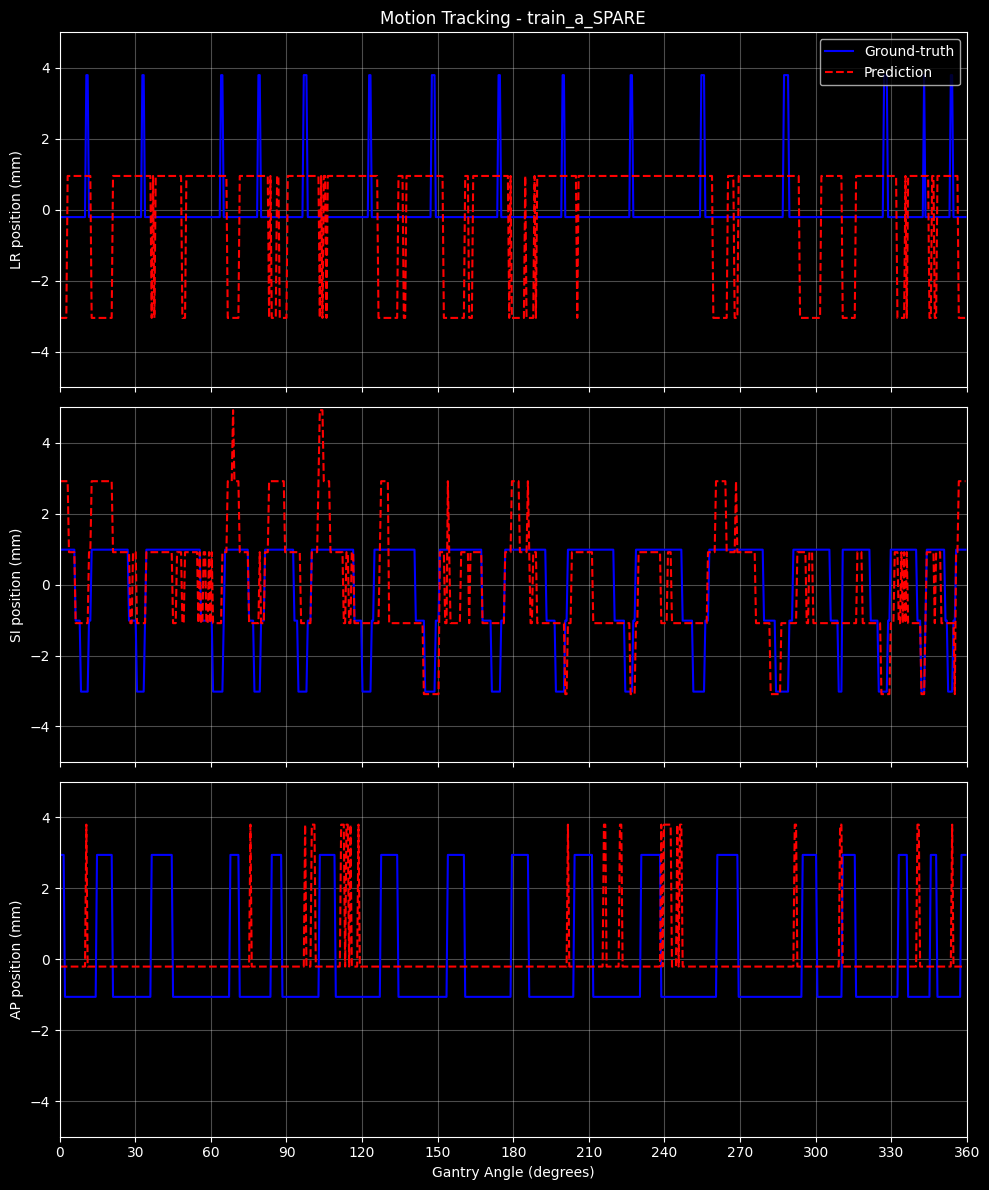

In [112]:
# 1. Print Results
# Calculate 3D Euclidean distance between Ground-Truth and Predicted centroids
dx = np.asarray(tar_lr) - np.asarray(pred_lr)
dy = np.asarray(tar_si) - np.asarray(pred_si)
dz = np.asarray(tar_ap) - np.asarray(pred_ap)
error_3d = np.sqrt(dx**2 + dy**2 + dz**2)

print('--- Global Metrics ---')
# Check if test_dice has content before printing to avoid mean of empty slice errors
if test_dice:
    print('[Target PTV Dice: %.2f ± %.2f]' % (np.mean(test_dice), np.std(test_dice)))

print('[3D Error (mm): %.1f ± %.1f | Jacobian detJ: %.0E]' % (np.mean(error_3d), np.std(error_3d), np.mean(test_detJ)))

# Consolidated OAR Print (Lung Only)
if lung_dice:
    print('[Lung ITV DSC: %.2f ± %.2f]' % (np.mean(lung_dice), np.std(lung_dice)))

print('[SSIM: %.2f ± %.2f | PSNR: %.1f ± %.1f]' % (np.mean(test_ssim), np.std(test_ssim), np.mean(test_psnr), np.std(test_psnr)))

# 2. Plot Centroid Traces
# Zero-center the traces for better comparison of motion amplitude
def prepare_trace(trace, angles):
    trace = np.asarray(trace)
    trace = trace - np.mean(trace)
    return [t for _, t in sorted(zip(angles, trace))]

tar_lr_plot = prepare_trace(tar_lr, test_angles)
tar_si_plot = prepare_trace(tar_si, test_angles)
tar_ap_plot = prepare_trace(tar_ap, test_angles)

pred_lr_plot = prepare_trace(pred_lr, test_angles)
pred_si_plot = prepare_trace(pred_si, test_angles)
pred_ap_plot = prepare_trace(pred_ap, test_angles)

sorted_angles = sorted(test_angles)

# Plotting
f, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
labels = ['LR position (mm)', 'SI position (mm)', 'AP position (mm)']
data_tar = [tar_lr_plot, tar_si_plot, tar_ap_plot]
data_pred = [pred_lr_plot, pred_si_plot, pred_ap_plot]

for idx, ax in enumerate(axes):
    ax.plot(sorted_angles, data_tar[idx], label='Ground-truth', color='blue')
    ax.plot(sorted_angles, data_pred[idx], label='Prediction', color='red', linestyle='--')
    ax.set_ylabel(labels[idx])
    ax.set_ylim([-5, 5]) # Adjusted for typical lung motion range
    ax.set_xlim([0, 360])
    ax.set_xticks(np.arange(0, 361, 30))
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.set_title(f'Motion Tracking - {expt_file}')
        ax.legend(loc='upper right')
    if idx == 2:
        ax.set_xlabel('Gantry Angle (degrees)')



f.tight_layout()
plt.savefig('plots/' + expt_file + '_trace.png')
plt.show()

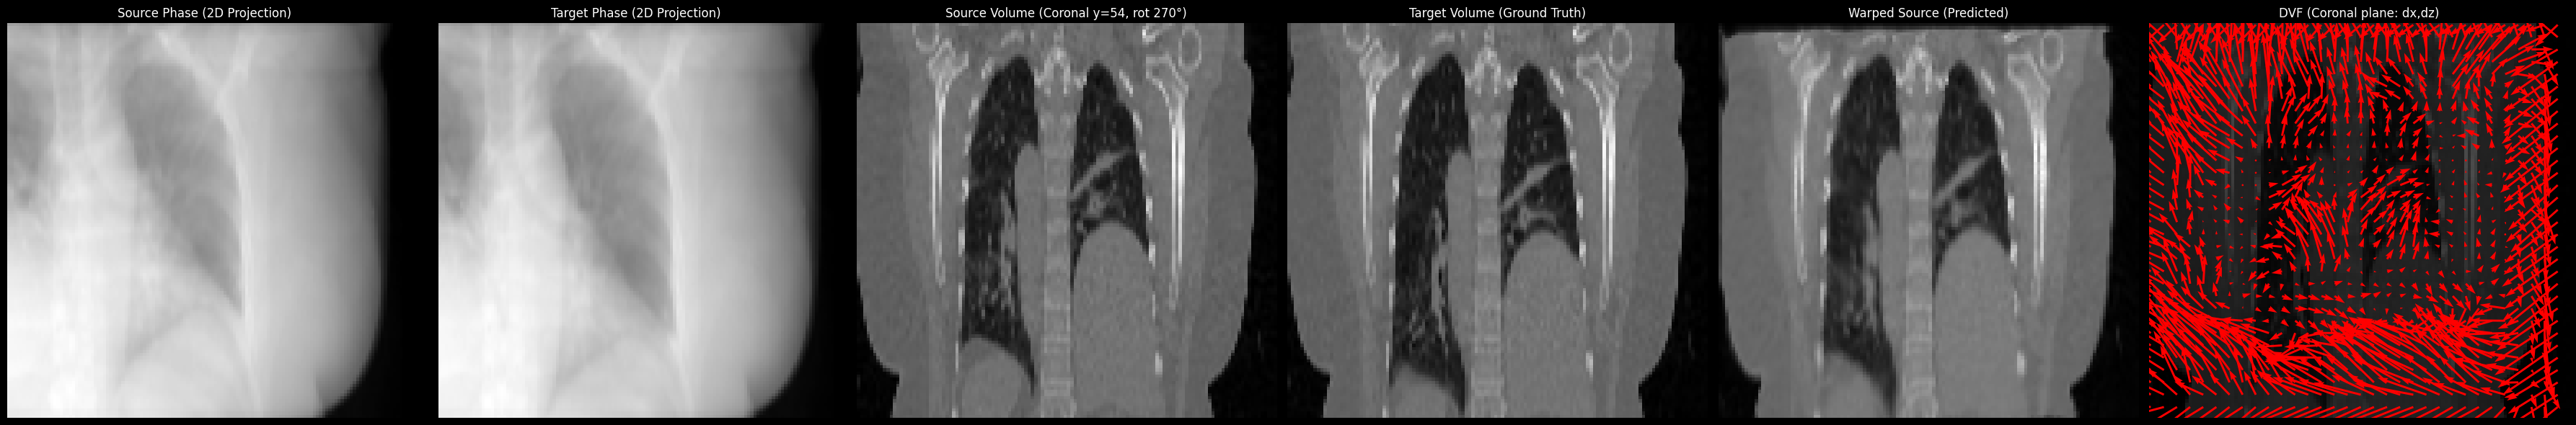

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()

# 1. Get a sample
data = next(iter(testloader))

source_proj = data['source_projections'].to(device)
target_proj = data['target_projections'].to(device)
source_vol  = data['source_volumes'].to(device)
target_vol  = data['target_volumes'].to(device)
source_ptv  = data['source_ptv'].to(device)

# 2. Forward pass
with torch.no_grad():
    _, predict_flow = model(source_proj, target_proj, source_ptv)
    predict_vol = transformer(source_vol, predict_flow)

# 3. Pick CORONAL slice index (y index, front view)
# Volume assumed (B, C, D, H, W) where D=z, H=y, W=x
y_idx = 54 # middle along H (y). You can set y_idx=52 etc.

# 4. Extract coronal slices: (z, x)
src_c = source_vol[0, 0, :, :, y_idx].detach().cpu().numpy()
tar_c = target_vol[0, 0, :, :, y_idx].detach().cpu().numpy()
prd_c = predict_vol[0, 0, :, :, y_idx].detach().cpu().numpy()

flow_np = predict_flow[0].detach().cpu().numpy()  # (3, D, H, W) usually

# For coronal plane, use x and z components:
# dx = flow[0], dz = flow[2]
fx_c = flow_np[0, :, y_idx, :]   # (z, x)
fz_c = flow_np[2, :, y_idx, :]   # (z, x)

# 5. Rotate everything 90° CCW to match your displayed orientation
k = 3  # 1=90° CCW, 3=270° CCW (90° CW)
rot = lambda a: np.rot90(a, k=k)

src = rot(src_c)
tar = rot(tar_c)
prd = rot(prd_c)

fx  = rot(fx_c)
fz  = rot(fz_c)

# 6. Rotate vector components consistently with the image rotation
# After 90° CCW rotation: (u', v') = (-v, u)
if k % 4 == 1:          # 90° CCW
    u_field = -fz
    v_field =  fx
elif k % 4 == 3:        # 270° CCW (90° CW)
    u_field =  fz
    v_field = -fx
elif k % 4 == 2:        # 180°
    u_field = -fx
    v_field = -fz
else:                   # 0°
    u_field = fx
    v_field = fz

# 7. Projections (kept as-is)
source_phase_2d = source_proj[0, 0].detach().cpu().numpy()
target_phase_2d = target_proj[0, 0].detach().cpu().numpy()

# 8. Plot
fig, axes = plt.subplots(1, 6, figsize=(36, 6))

axes[0].imshow(source_phase_2d, cmap='gray')
axes[0].set_title('Source Phase (2D Projection)')

axes[1].imshow(target_phase_2d, cmap='gray')
axes[1].set_title('Target Phase (2D Projection)')

axes[2].imshow(src, cmap='gray', aspect='auto')
axes[2].set_title(f'Source Volume (Coronal y={y_idx}, rot {k*90}°)')

axes[3].imshow(tar, cmap='gray', aspect='auto')
axes[3].set_title('Target Volume (Ground Truth)')

axes[4].imshow(prd, cmap='gray', aspect='auto')
axes[4].set_title('Warped Source (Predicted)')

# DVF quiver over target (same orientation)
step = 4
H, W = tar.shape
Y, X = np.mgrid[0:H:step, 0:W:step]

u = u_field[::step, ::step]
v = v_field[::step, ::step]

axes[5].imshow(tar, cmap='gray', alpha=0.3, aspect='auto')
axes[5].quiver(X, Y, u, -v, color='red', scale=10, width=0.005)  # -v for imshow's y-axis direction
axes[5].set_title('DVF (Coronal plane: dx,dz)')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


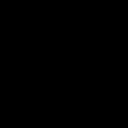

Saved to: /home/saatwik/Desktop/voxelmap/Voxelmap-main/subCT_02a2.gif


In [105]:
import numpy as np
import imageio.v2 as imageio
from IPython.display import Image, display

def save_ct_gif_from_npy(npy_path, out_path="ct.gif", axis=2, fps=12, p_low=0.5, p_high=99.5):
    vol3d = np.squeeze(np.load(npy_path))
    v = np.moveaxis(vol3d, axis, 0)

    vmin, vmax = np.percentile(v, [p_low, p_high])
    v = np.clip(v, vmin, vmax)
    v = (v - vmin) / (vmax - vmin + 1e-8)
    frames = (v * 255).astype(np.uint8)

    imageio.mimsave(out_path, frames, duration=1.0/fps)
    display(Image(filename=out_path))
    print("Saved to:", out_path)

ct_path = "/srv/shared/SPARE/MC_V_P1_SC_02/subCT_02_mha.npy"
save_ct_gif_from_npy(ct_path, out_path="/home/saatwik/Desktop/voxelmap/Voxelmap-main/subCT_02a2.gif", axis=2, fps=12)


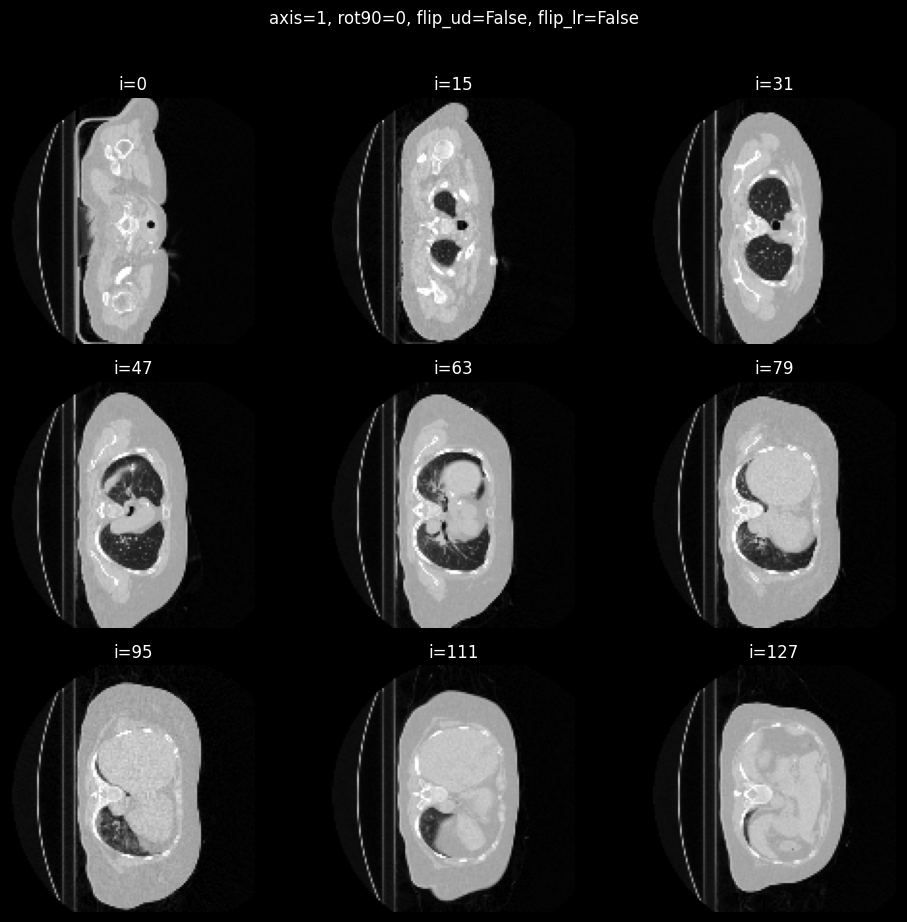

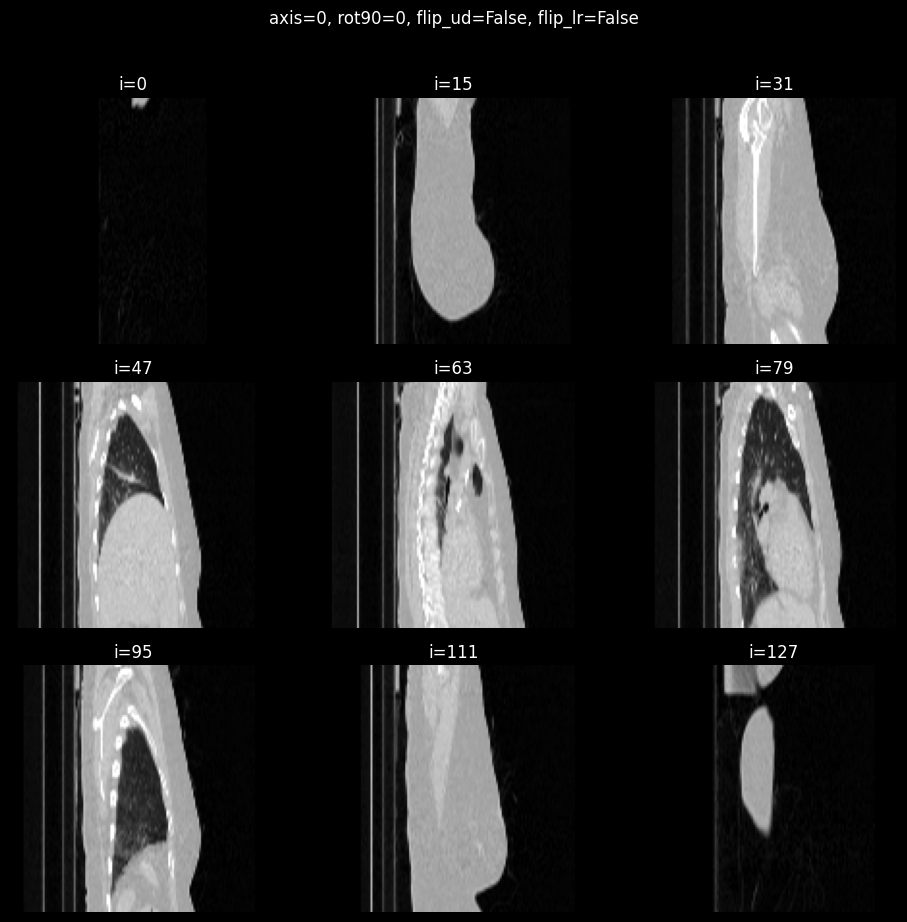

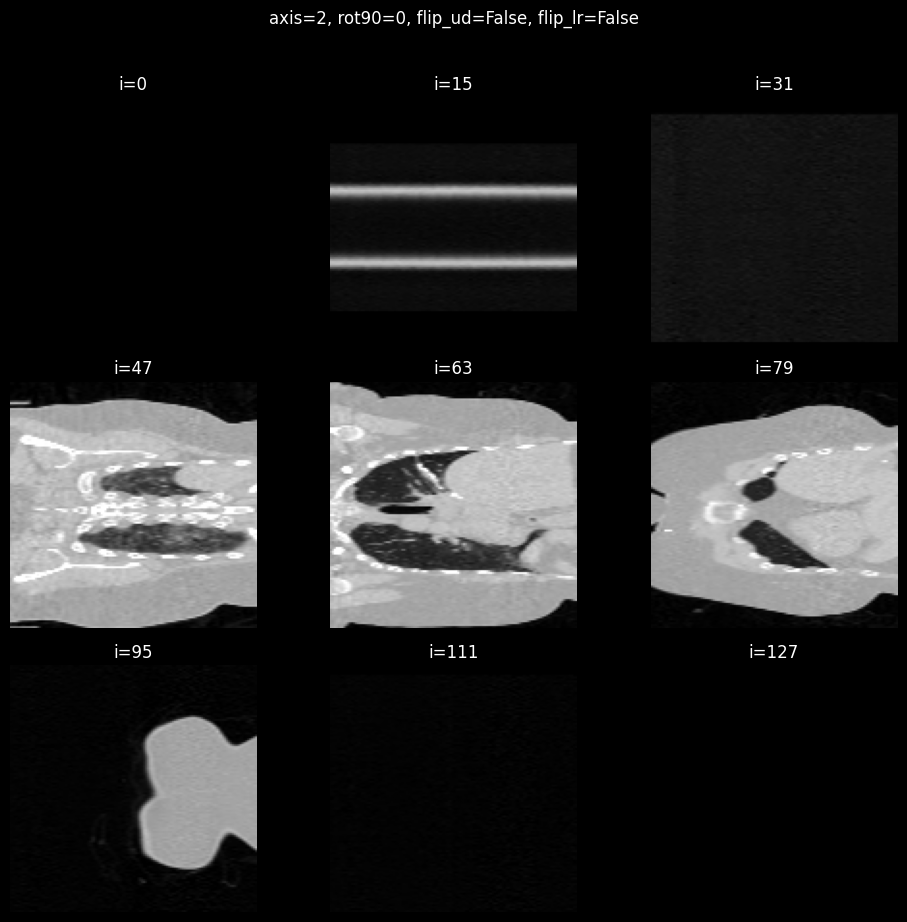

In [107]:
import numpy as np
import matplotlib.pyplot as plt

ct_path = "/srv/shared/SPARE/MC_V_P1_SC_02/subCT_02_mha.npy"
vol = np.squeeze(np.load(ct_path))

def orient_slice(img2d, rot90=0, flip_ud=False, flip_lr=False):
    x = img2d
    if rot90 % 4 != 0:
        x = np.rot90(x, k=rot90)
    if flip_ud:
        x = np.flipud(x)
    if flip_lr:
        x = np.fliplr(x)
    return x

def montage(vol3d, slice_axis=1, rot90=0, flip_ud=False, flip_lr=False, n=9, p_low=0.5, p_high=99.5):
    v = np.moveaxis(vol3d, slice_axis, 0)  # [S,H,W]
    vmin, vmax = np.percentile(v, [p_low, p_high])

    idxs = np.linspace(0, v.shape[0]-1, n).astype(int)
    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(10, 3*rows))
    for k, i in enumerate(idxs):
        plt.subplot(rows, cols, k+1)
        plt.imshow(orient_slice(v[i], rot90, flip_ud, flip_lr), cmap="gray", vmin=vmin, vmax=vmax)
        plt.title(f"i={i}")
        plt.axis("off")
    plt.suptitle(f"axis={slice_axis}, rot90={rot90}, flip_ud={flip_ud}, flip_lr={flip_lr}", y=1.02)
    plt.tight_layout()
    plt.show()

# Try a few combinations:
montage(vol, slice_axis=1, rot90=0)   # looked best for you earlier
montage(vol, slice_axis=0, rot90=0)
montage(vol, slice_axis=2, rot90=0)

# If something is sideways, try rot90=1 or 3:
# montage(vol, slice_axis=1, rot90=1)
# montage(vol, slice_axis=1, rot90=3)


Heres how your breathing phase, and angle change with time!

In [108]:
import os, re, numpy as np

im_dir = test_file

def proj_num(fname):
    m = re.search(r"Proj_(\d+)", fname)
    return int(m.group(1)) if m else -1

proj_list = [n for n in os.listdir(im_dir) if n.startswith("Proj_") and n.endswith("_bin.npy")]
proj_list = sorted(proj_list, key=proj_num)

resp_bins = np.genfromtxt(os.path.join(im_dir, "RespBin.csv"))
angles    = np.genfromtxt(os.path.join(im_dir, "Angles.csv"))

print("num projections:", len(proj_list))
print("len RespBin.csv:", len(resp_bins))
print("len Angles.csv :", len(angles))

# show a few pairings
for idx in [0, 1, 2, 10, 20, len(proj_list)//2, len(proj_list)-1]:
    fname = proj_list[idx]
    print(f"idx={idx:4d}  {fname:18s}  proj={proj_num(fname):5d}  respbin={int(resp_bins[idx])}  angle={float(angles[idx]):.2f}")


num projections: 680
len RespBin.csv: 680
len Angles.csv : 680
idx=   0  Proj_00001_bin.npy  proj=    1  respbin=2  angle=0.00
idx=   1  Proj_00002_bin.npy  proj=    2  respbin=2  angle=0.53
idx=   2  Proj_00003_bin.npy  proj=    3  respbin=2  angle=1.06
idx=  10  Proj_00011_bin.npy  proj=   11  respbin=4  angle=5.29
idx=  20  Proj_00021_bin.npy  proj=   21  respbin=7  angle=10.59
idx= 340  Proj_00341_bin.npy  proj=  341  respbin=1  angle=180.00
idx= 679  Proj_00680_bin.npy  proj=  680  respbin=1  angle=359.47
